
##Simulation Settings

In [ ]:
!pip install torch==1.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.0 

##Fast Train Unfolding

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.linalg import svd, eig
import math
import time
import scipy.io as sio

torch.set_printoptions(precision=5, sci_mode=False)



def set_params(n_0= 1, p_s= 1, B= 2, K= 7, P= 4, N= 2,
              L= 2, T= 5, epochs= 500, J= 10,
              W_is_phase_only= True, W_is_block_diag= True,
              batch_size= 50, pga_iters= 500, lr_mu_beta= 0.0001,
              lr_lambda= 0.001, binary_thresh= 0.5,
              mat_file_path= "/content/H_1000_2_8_7.mat", seed= 1,
              train_size= 750, valid_size= 250, lambdas_init= 0.0,
              gamma= 200 , project_every= 1, l1_target = 1.0, sharpness = 30,
              Q = 4, W_is_finite = False):
    """
    This function sets the general parameters of the algorithm.
    Used in order to save space in the code when running multiple simulations.
    All of these parameters are predifined and can be modified.
    :param n_0: noise power
    :param p_s: signal power
    :param B: number of frequency bins
    :param K: number of users to be served
    :param P: number of panels in the base station
    :param N: number of antennas in each panel
    :param L: number of outputs in each panel
    :param T: number of inputs to the CPU
    :param epochs: number of epochs in the training
    :param J: number of iteration to be unfolded , usually 10.
    :param batch_size: batch size in the training part.
    :param pga_iters: number of iterations in the PGA algorithm to be compared with.
    :param lr_mu_beta: learning rate of the optimizer. denoted as eta in the paper.
    :param lr_lambda: learning rate of the optimizer for optimzing lambda.
    :param binary_thresh: the threshold for setting elements to zero in the projection onto phases.
    :param train_size: size of the channel realizations taken to training set.
    :param valid_size: size of the channel realizations taken to validation set.
    :return: all the parameters.
    """

    # General parameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    M = P * N  # Total number of antennas in the Base station
    Ik = torch.eye(T, dtype=torch.complex128, device = device)
    Im = torch.eye(M, dtype=torch.complex128, device = device)
    snr = p_s / n_0

    # Building the A matrix using the examples given in the paper
    # "Trade-Offs in Decentralized Multi-Antenna Architectures: The WAX Decomposition"
    if T==5:
        A = torch.empty((L * P, T))
        A[:T, :] = torch.eye(T)
        A[T:, :3] = torch.eye(3)
        A[T:, 3:] = 1
        A = A.to(dtype=torch.complex128, device = device)
    if T == 61: # suitable only for the case where L*P = 100

        A = torch.empty((100, 61))
        A[ :61, :] = torch.eye(61)
        A[61:, :39] = torch.eye(39)
        A[61:83, 39:] = torch.eye(22)
        A[83:, 39:56] = torch.eye(17)
        A[83:88, 56:] = torch.eye(5)
        A[88:93, 56:] = torch.eye(5)
        A[93:98, 56:] = torch.eye(5)
        A[98:, 56:58] = torch.eye(2)
        A[98:, 58:60] = torch.eye(2)
        A = A.to(dtype=torch.complex128, device = device)

    # Creating D to be a mask matrix that will be used to project the matrix W onto a block diagonal matrix.
    D = torch.zeros((M, L * P), device = device)
    for p in range(P):
        p_n, p_l = p * N, p * L
        D[p_n:(p_n + N), p_l:(p_l + L)] = torch.ones((N, L))

    # creating W:
    torch.manual_seed(seed)
    W_vec =torch.exp(2*math.pi * torch.rand((N*L*P), device = device, dtype= torch.complex128))
    W_blocks = W_vec.view(P, N, L)
    W_block_list = [W_blocks[i] for i in range(P)]
    W = torch.block_diag(*W_block_list)

    return W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J, epochs, W_is_block_diag, W_is_phase_only, batch_size, pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size, valid_size, lambdas_init, gamma , mat_file_path, project_every, l1_target, device, sharpness, Q, W_is_finite


def soft_mag_proj(w, binary_thresh, sharpness):
    w = torch.exp(1j*torch.angle(w)) / (1 + torch.exp(-sharpness * (torch.abs(w) - binary_thresh)))
    return w


def hard_mag_proj(w, binary_thresh):
    w = D * torch.exp(1j*torch.angle(w)) * torch.where(torch.abs(w) < binary_thresh, torch.zeros_like(w), torch.ones_like(w))
    return w


def soft_phase_proj(W, sharpness):
    output_phase = torch.zeros_like(W)
    for q in range(1, Q + 1):
        # Calculate the shifted and normalized sigmoid for each q
        sigmoid_output_q = 2*np.pi/(1+torch.exp(-sharpness*(W.angle()-(q-0.5)*2*torch.pi/Q + np.pi))) - np.pi
        output_phase += sigmoid_output_q / Q
    return output_phase


def hard_phase_proj(W):
    output_phase = torch.zeros_like(W)
    for q in range(0, Q+1):
        # Calculate the shifted and normalized step function for each q
        step_output_q = torch.where((W.angle() >= (q-0.5)*2*np.pi/Q - np.pi) & (W.angle() < (q+0.5)*2*np.pi/Q - np.pi), q*2*np.pi/Q - np.pi, 0.0)
        output_phase += step_output_q
    return output_phase


class FastTrainUnfolding(nn.Module):
    def __init__(self, W, J, forward_path='Unfolding', mu = None, beta = None, cnn_layers = 10):
        super(FastTrainUnfolding, self).__init__()
        self.J = J
        self.W = W.detach().clone()  # Make a copy to avoid modifying the original W
        self.ones = torch.ones(1, dtype = torch.float64, device = device)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.pga_iters = pga_iters
        self.constant_mu = mu
        self.constant_beta = beta
        self.cnn_layers = cnn_layers
        self.PE = project_every


        # Define layers for Unfolded:
        self.Mu = nn.ModuleList([nn.Linear(1, P*N*L, dtype = torch.float64) for _ in range(J)])
        self.Beta = nn.ModuleList([nn.Linear(1, P*N*L, dtype = torch.float64) for _ in range(J)])
        self.Lambda = nn.ModuleList([nn.Linear(1, P*N*L, dtype = torch.float64) for _ in range(J)])

        if forward_path == "CNN":
            # Define layers for the CNN.
            mag_layers = []
            for _ in range(self.cnn_layers - 1):
              mag_layers.extend([nn.Conv2d(B, B, kernel_size = 4, padding = 2, stride = 1, dtype = torch.float64),
                                nn.MaxPool2d(kernel_size = 2, stride = 2),
                                nn.Flatten(),
                                nn.Linear(((M+1)//2 * ((K+1)//2) * B ), B*M*K, dtype = torch.float64),
                                nn.Unflatten(-1,(B,M,K)),
                                nn.BatchNorm2d(B, dtype = torch.float64),
                                ])
            self.cnn_mag = nn.Sequential(*mag_layers)

            phase_layers = []
            for _ in range(self.cnn_layers - 1):
              phase_layers.extend([nn.Conv2d(B, B, kernel_size = 4, padding = 2, stride = 1, dtype = torch.float64),
                                nn.BatchNorm2d(B, dtype = torch.float64),
                                nn.MaxPool2d(kernel_size = 2, stride = 2),
                                nn.Flatten(),
                                nn.Linear(((M+1)//2 * ((K+1)//2) * B), B*M*K, dtype = torch.float64),
                                nn.Unflatten(-1,(B,M,K))
                                ])
            self.cnn_phase = nn.Sequential(*phase_layers)


            self.cnn_f_layer = nn.Linear(2 * B * M * K, N * P * L, dtype = torch.float64)

        # Define the selected forward path
        if forward_path == 'Unfolding':
            self.forward_path = self.forward_unfolded
        elif forward_path == 'Constant':
            self.forward_path = self.forward_constant
        elif forward_path == "CNN":
            self.forward_path = self.forward_cnn
        else:
            raise ValueError("Invalid forward_path. Choose 'Unfolding' or 'constant'.")


    def forward(self, H):
        return self.forward_path(H)


    def forward_cnn(self, H):
        # Convert complex number to magnitude and phase
        H_mag, H_phase = torch.abs(H), torch.angle(H)

        # Pass through the neural network layers
        output_mag = self.cnn_mag(H_mag).view(H_mag.size(0), -1)
        output_phase = self.cnn_phase(H_phase).view(H_phase.size(0), -1)
        final_vec = torch.cat((output_mag, output_phase), dim=1)

        # Convert magnitude and phase back to complex number
        W_phases_vec = self.cnn_f_layer(final_vec)
        # if W_is_finite:
        #     W_phases_vec = hard_phase_proj(W_phases_vec)
        W_phases_blocks = W_phases_vec.view(-1,P,N,L)
        W_pred = D * torch.exp(1j * 2*math.pi * vec_2_blk_diag(W_phases_vec, batch=True))
        cnn_R = self.calc_R(H,W_pred)
        return W_pred, cnn_R


    def forward_unfolded(self, H):
        W_1 = self.W.clone()
        Rs = torch.zeros(H.shape[0], J)
        l1_norms = torch.zeros(H.shape[0], J)
        W_0 = torch.zeros_like(W_1)
        for j in range(self.J):
            grad = self.calc_dR_dW(H, W_1)
            Mu_step = vec_2_blk_diag(self.Mu[j](self.ones)) * grad
            Momentum = vec_2_blk_diag(self.Beta[j](self.ones)) * (W_1 - W_0)
            norm_reduc = 0.001*vec_2_blk_diag(self.Lambda[j](self.ones)) * torch.exp(1j*torch.angle(W_1))
            ## Updating:
            W_2 = W_1 + Mu_step + Momentum - norm_reduc

            ## Projecting:
            ## If training, use Soft Projecting:
            if (j+1) % self.PE == 0 and self.training:
                W_2 = D * soft_mag_proj(W_2, binary_thresh = binary_thresh, sharpness = sharpness)
                if W_is_finite:
                    W_2 = D * torch.exp(1j*soft_phase_proj(W_2, sharpness = sharpness))

            ## If Validating, use Hard Projecting:
            if (j+1) % self.PE == 0 and not self.training:
                W_2 = hard_mag_proj(W_2, binary_thresh = binary_thresh)
                if W_is_finite:
                    W_2 = D * torch.exp(1j*hard_phase_proj(W_2))


            ## Documenting:
            l1_norms[:,j] = torch.norm(W_2, p=1)
            Rs[:,j] = self.calc_R(H, W_2)
            W_0 = W_1
            W_1 = W_2

        return W_2, Rs, l1_norms


    def forward_constant(self, H):
        W_1 = self.W.clone()
        W_0 = torch.zeros_like(W_1)
        Rs = torch.zeros(H.shape[0], self.pga_iters)
        for iter in range(self.pga_iters):
            grad = self.calc_dR_dW(H, W_1)
            Mu_step = self.constant_mu * grad
            Momentum = self.constant_beta * (W_1 - W_0)
            ## Updating:
            W_2 = W_1 + Mu_step + Momentum
            ## Projecting:
            if (iter+1) % self.PE == 0:
                W_2 = D * (torch.exp(1j * torch.angle(W_2)))
                if W_is_finite:
                    W_2 = D * torch.exp(1j*hard_phase_proj(W_2))

            ## Documenting:
            Rs[:,iter] = self.calc_R(H, W_2)
            W_0 = W_1
            W_1 = W_2
        return W_2, Rs


    def calc_dR_dW(self, H, W):
        """calculates the gradient of the rate with respect to W. the gradient has the same dimension as W"""
        grad = torch.zeros(H.size(0), M, L*P, dtype = torch.complex128, device =self.device)
        for b in range(B):
            h1 = H[:,b, :, :]
            W_con = W.conj()
            H_con = h1.conj()
            G = W @ A
            if len(G.shape) < 3:
              G = G.unsqueeze(0).repeat(H.shape[0], 1, 1)
            G_herm = G.transpose(1, 2).conj()
            h1_herm = h1.transpose(1, 2).conj()
            G_psu_inv = torch.inverse(G_herm @ G + 10**-6 * torch.eye(T, device = self.device))
            Proj_mat = G @ G_psu_inv @ G_herm
            Z = snr * G_psu_inv @ G_herm @ h1 @ h1_herm @ G
            dR_dZ = torch.inverse(Ik + Z)
            diff = snr * (A @ dR_dZ @ (2 * G_psu_inv @ G_herm) @ h1 @ h1_herm @ (Im - Proj_mat)).conj().transpose(1,2)
            grad += diff
        return grad / B


    def calc_R(self, H, W):
        R = 0
        G = W @ A
        G_herm = G.transpose(1, 2).conj()
        for b in range(B):
          h1 = H[:,b,:,:]
          h1_herm = h1.transpose(1, 2).conj()
          psudo_inv_G = torch.inverse(G_herm @ G + 10**-6 * torch.eye(T,device = self.device))
          proj_mat = G @ psudo_inv_G @ G_herm
          R += torch.log((Im + snr * proj_mat @ h1 @ h1_herm).det())
        return R/B


class QuaDRiGA(Dataset):
    def __init__(self):
        self.num_samples = valid_size + train_size
        self.H = sio.loadmat(mat_file_path)['H']
        self.H = torch.tensor(self.H.transpose(0, 3, 2, 1)).to(device)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.H[idx,:B,:,:]
        return sample


class IID(Dataset):
    def __init__(self):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_samples = valid_size + train_size
        self.H = torch.randn((self.num_samples,B,M,K), dtype = torch.complex128, device = device)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.H[idx,:,:,:]
        return torch.tensor(sample)


def vec_2_blk_diag(vec, batch=False):
    if batch:
        size_batch = vec.shape[0]
        assert len(vec.shape) == 2, "Invalid shape for batched vector"
        assert vec.shape[1] == P * N * L, "Invalid vector length for batched vector"
        blocks = vec.view(size_batch, P, N, L)
    else:
        assert len(vec.shape) == 1, "Invalid shape for non-batched vector"
        assert vec.shape[0] == P * N * L, "Invalid vector length for non-batched vector"
        blocks = vec.view(P, N, L)

    if batch:
        result_matrix = torch.cat([torch.block_diag(*blocks[i].unbind(0)).unsqueeze(0) for i in range(size_batch)], dim=0)
    else:
        result_matrix = torch.block_diag(*blocks.unbind(0)).unsqueeze(0)

    return result_matrix


def train_and_plot(model, num_epochs, train_loader, val_loader, cnn = False, seq_learning = False, pre_model= None, plot = True):
    train_losses = []
    val_losses = []
    l1_norms_list_train = []
    l1_norms_list_val = []
    log_weights = torch.log(torch.arange(2, J + 2))

    # Training
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_l1_norms = 0.0
        for H_batch in train_loader:
            if not cnn: # If we are training the Unfolded network
                u_optimizer.zero_grad()
                lam_optimizer.zero_grad()
                if seq_learning:
                    W_out_pre,Rs_pre = pre_model(H_batch)
                    model.W = W_out_pre
                W_out_u, Rs, l1_norms = model(H_batch)
                l1_norms = l1_norms.mean(dim=0) / (N*P*L*(Rs.shape[0])) # averaging on them
                Rs = Rs.mean(dim = 0) # averaging on them

                loss = -torch.sum(Rs * log_weights) # Taking the last value of R for each sample
                loss += gamma * (torch.sum(log_weights*(l1_norms - l1_target)**2))
                loss.backward()
                u_optimizer.step()
                lam_optimizer.step()

                total_train_loss += Rs[-1].item() / K
                total_l1_norms += l1_norms[-1].item()


            else: # If we are training the CNN network
                cnn_optimizer.zero_grad()
                W_out_cnn, cnn_R = model(H_batch)
                if seq_learning: # Learning a sequence of networks
                    pre_model.W = W_out_cnn
                    W_out_post, Rs_post, _ = pre_model(H_batch)
                    loss = -torch.sum(Rs_post.mean(dim=0) * log_weights) # Taking the last value of R for each sample
                    loss.backward()
                    cnn_optimizer.step()
                    total_train_loss += Rs_post.mean(dim=0)[-1].item() / K

                else: # Regular Learning of CNN
                    cnn_R = cnn_R.mean(dim = 0) # averaging on them
                    loss = -cnn_R
                    loss.backward()
                    cnn_optimizer.step()
                    total_train_loss += cnn_R.item() / K


        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)
        if not cnn:
          l1_norms_list_train.append(total_l1_norms / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            val_rate = 0.0
            total_l1_norms_v = 0.0
            for H_val_batch in val_loader:
                if not cnn: # If we are training the Unfolded network
                    if seq_learning:
                        W_out_pre,Rs_pre = pre_model(H_val_batch)
                        model.W = W_out_pre
                    W_val_pred, Rs_val, l1_norms_v = model(H_val_batch)
                    l1_norms_v = l1_norms_v.mean(dim=0) / (P*N*L*(Rs_val.shape[0]))
                    Rs_val = Rs_val.mean(dim=0) / K
                    val_rate += Rs_val
                    total_val_loss += Rs_val[-1].item()
                    total_l1_norms_v += l1_norms_v[-1].item()
                else: # If we are training the CNN network
                    W_val_pred, cnn_R_val = model(H_val_batch)
                    if seq_learning:
                        pre_model.W = W_val_pred
                        W_val_post,Rs_post,_ = pre_model(H_val_batch)
                        cnn_R_val = Rs_post.mean(dim=0)[-1] / K
                    else:
                        cnn_R_val = cnn_R_val.mean(dim=0) / K
                    val_rate += cnn_R_val
                    total_val_loss += cnn_R_val.item()

            average_val_loss = total_val_loss / len(val_loader)
            val_rate = val_rate / len(val_loader)
            val_losses.append(average_val_loss)
            if not cnn:
                l1_norms_list_val.append(total_l1_norms_v / len(val_loader))



        # Print the loss for each epoch
        if (epoch +1) % 50 == 0:
          print(f'Epoch [{epoch + 1}/{num_epochs}], '
                f'Training: {round(abs(average_train_loss), 5)}, '
                f'Validation: {round(abs(average_val_loss), 5)}')

    if plot:
        # Plot the training and validation losses
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Valid')
        plt.xlabel('Epochs')
        plt.ylabel('Channel Rate')
        plt.title('CNN Training' if cnn else 'Unfolding Training')
        plt.legend()
        plt.grid()
        plt.show()
    return val_rate, model, l1_norms_list_val, l1_norms_list_train


def constant_mu_and_beta_search():
  mu_grid = torch.cat((torch.linspace(0.01,0.5,6),torch.linspace(1,5,5)))
  beta_grid = torch.cat((torch.linspace(0,0.99,3),torch.tensor([0.9])))
  search_Rs = 0
  best_Rs = torch.zeros(pga_iters)
  best_mu = 0
  best_beta = 0
  indices = np.arange(project_every, pga_iters +1, project_every)
  for mu in mu_grid:
      for beta in beta_grid:
        con_model = FastTrainUnfolding(W, J, "Constant", mu, beta)
        search_Rs = 0
        for H_val_batch in val_loader:
          W_val_pred, Rs_val = con_model(H_val_batch)
          Rs_val = Rs_val.mean(dim=0) / K
          search_Rs += Rs_val
        search_Rs = search_Rs / len(val_loader)
        if max(abs(search_Rs[indices-1])) > max(abs(best_Rs[indices-1])):
          best_Rs = search_Rs
          best_mu = mu
          best_beta = beta
          # print(f' Updated, mu: {round(mu.item(),2)}, beta: {round(beta.item(),2)}, R: {round(max(abs(best_Rs)).item(),6)}')

  print(f'best mu: {round(best_mu.item(),2)}, best beta: {round(best_beta.item(),2)}, best R: {round(max(abs(best_Rs)).item(),6)}')
  return best_Rs, best_mu, best_beta


def plot_R(unfolding_R, best_Rs, ls_Rs, cnn_R, Mo_Rs, alt_learn_Rs= None, full=False):
    indices = np.arange(project_every,len(best_Rs)+1, project_every)
    u_indices = np.arange(project_every,len(unfolding_R)+1,project_every)
    ls_indices = np.arange(project_every,len(ls_Rs)+1, project_every)
    mo_indices = np.arange(project_every,len(Mo_Rs)+1, project_every)

    plt.plot(u_indices, unfolding_R[u_indices-1],"-o", label='U-PGA+M', color = "blue")
    plt.plot(indices, best_Rs.detach().numpy()[indices-1],"--^", label = "PGA+M", color = "orange")
    plt.plot(ls_indices, ls_Rs.detach().numpy()[ls_indices-1],"--*", label = "Line Search", color = "green")
    plt.plot(mo_indices, Mo_Rs.detach().numpy()[mo_indices-1],"-.", label = "MO", color = "cyan")
    if alt_learn_Rs is not None:
          alt_Rs_indices = np.arange(project_every,len(alt_learn_Rs)+1, project_every)
          plt.plot(alt_Rs_indices, alt_learn_Rs.detach().numpy()[alt_Rs_indices-1],"-x", label = "CNN + U-PGA+M", color = "red")

    plt.axhline(y=abs(cnn_R.item()), color='magenta', linestyle=':', label="CNN - {} layers".format(cnn_model.cnn_layers))
    plt.axhline(y=max(abs(best_Rs[indices-1].detach().numpy())), color='black', linestyle='--', label='PGA+M - {} iters'.format(pga_iters))

    plt.xlabel('Iteration')
    plt.ylabel("Bits per channel use per user")
    plt.legend()
    plt.grid()
    if not full:
        plt.xlim(project_every,J)
    plt.show()


def plot_norms():
    plt.plot(range(1,len(u_l1_norms_v)+1),u_l1_norms_v, label="Valid")
    plt.plot(range(1,len(u_l1_norms_t)+1),u_l1_norms_t, label= "Train")
    plt.ylabel('% of components on')
    plt.xlabel("epochs")
    plt.axhline(y=l1_target, color='k', linestyle='--', label = "target")
    plt.grid()
    plt.title("L1 Norms")
    plt.legend()
    plt.show()


def gen_data(train_size,valid_size,dataset="QuaDRiGA"):
  if dataset == "QuaDRiGA":
    dataset = QuaDRiGA()

  if dataset == "I.I.D.":
      dataset = IID()

  # # Split the dataset into training and validation sets
  train_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
  val_dataset = torch.utils.data.Subset(dataset, range(valid_size))

  # # Create DataLoaders for training and validation
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  val_loader_singles = DataLoader(val_dataset, batch_size=1, shuffle=True)
  return train_loader, val_loader, val_loader_singles


def show_mu_and_beta(model):

    # Create subplots for Mu
    fig, axs_mu = plt.subplots(2, (J + 1) // 2, figsize=(21, 8.5))

    # Calculate global min and max for Mu
    global_min_mu = min([min(model.Mu[j](model.ones)) for j in range(J)])
    global_max_mu = max([max(model.Mu[j](model.ones)) for j in range(J)])

    # After training is complete
    for j, linear_layer in enumerate(model.Mu):
        # Pass ones vector through the linear layer, to see its values
        Mu_j = vec_2_blk_diag(model.Mu[j](model.ones))


        # Plot magnitude
        im1 = axs_mu[j // ((J + 1) // 2), j % ((J + 1) // 2)].imshow(Mu_j.squeeze(0).cpu().detach().numpy(), cmap='viridis', vmin=global_min_mu, vmax=global_max_mu)
        axs_mu[j // ((J + 1) // 2), j % ((J + 1) // 2)].set_title(f'Layer {j}')

    # Create a colorbar for Mu
    cbar_mu_ax = fig.add_axes([0.25, 0.08, 0.5, 0.07])  # [left, bottom, width, height]
    cbar_mu = fig.colorbar(im1, cax=cbar_mu_ax, orientation='horizontal')

    # Adjust layout for Mu and the colorbar
    plt.subplots_adjust(top=0.85, bottom=0.2, right=0.9 if J % 2 == 0 else 0.85)
    plt.suptitle('Mu', fontsize=40, y=0.95)
    plt.show()

    # Create subplots for Beta
    fig, axs_beta = plt.subplots(2, (J + 1) // 2, figsize=(21, 8.5))

     # Calculate global min and max for Mu
    global_min_beta = min([min(model.Beta[j](model.ones)) for j in range(J)])
    global_max_beta = max([max(model.Beta[j](model.ones)) for j in range(J)])


    # After training is complete
    for j, linear_layer in enumerate(model.Beta):
        # Pass ones vector through the linear layer, to see its values
        Beta_j = vec_2_blk_diag(model.Beta[j](model.ones))

        # Plot magnitude
        im1 = axs_beta[j // ((J + 1) // 2), j % ((J + 1) // 2)].imshow(Beta_j.squeeze(0).cpu().detach().numpy(), cmap='viridis', vmin=global_min_beta, vmax=global_max_beta)
        axs_beta[j // ((J + 1) // 2), j % ((J + 1) // 2)].set_title(f'Layer {j}')

    # Create a colorbar for Beta
    cbar_beta_ax = fig.add_axes([0.25, 0.08, 0.5, 0.07])  # [left, bottom, width, height]
    cbar_beta = fig.colorbar(im1, cax=cbar_beta_ax, orientation='horizontal')

    # Adjust layout for Beta and the colorbar
    plt.subplots_adjust(top=0.85, bottom=0.2, right=0.9 if J % 2 == 0 else 0.85)
    plt.suptitle('Beta', fontsize=40, y=0.95)
    plt.show()


def line_search(ls_iters):
    """ Iterates over every sample in the validation set, and finds the best step size for each iteration, for each sample. """
    # Initializing the PGA + M object with default values:
    ls_model = FastTrainUnfolding(W, J, "Constant")
    best_steps = torch.zeros((len(val_loader_sin)), ls_iters)
    best_Rs = torch.zeros((len(val_loader_sin)), ls_iters)
    grid = torch.cat((torch.linspace(0.01,0.5,6),torch.linspace(1,5,5)))
    # Takes a single sample:
    for idx, sample in enumerate(val_loader_sin):
        W_ls = W.detach().clone()
        sample.unsqueeze(0)
        # Start moving over all the iterations in "line_search_iters".
        for iteration in range(ls_iters):
            # initianting the best step and the best R to be 0:
            best_step = 0
            best_R = 0
            # Calculating the gradient:
            grad = ls_model.calc_dR_dW(sample, W_ls)
            # Looking for the best step size with the calculated gradient:
            for step in grid:
                # Updating W with the step size:
                W_temp = W_ls + step * grad
                if (iteration + 1) % project_every == 0:
                    W_temp = hard_mag_proj(W_temp,binary_thresh=0)
                    if W_is_finite:
                      W_temp = D * torch.exp(1j*hard_phase_proj(W_temp))

                # Calculating the optional R.
                R = ls_model.calc_R(sample, W_temp)
                if abs(R) > abs(best_R): # If the calculated R is better than the best R so far, save the step size.
                    best_R = R
                    best_step = step
            # Before the next iteration, update W with the best step chosen.
            W_ls = W_ls + best_step * grad
            if (iteration + 1) % project_every == 0:
                W_ls = hard_mag_proj(W_ls,binary_thresh= 0)
                if W_is_finite:
                    W_ls = D * torch.exp(1j*hard_phase_proj(W_ls))
            best_steps[idx,iteration] = best_step # saving the best step and the best R.
            best_Rs[idx,iteration] = best_R
    average_best_Rs = torch.mean(best_Rs, dim=0)  # Calculate the mean R
    average_best_steps = torch.mean(best_steps, dim=0)  # Calculate the mean best step size, for comparison reasons.
    return average_best_Rs / K, average_best_steps


def manifold_optimization(MO_iters):
    """ Iterates over every sample in the validation set, and finds the best step size for each iteration,
     following the objective of approching G_opt, achieved by SVD. """
    # Initializing the PGA + M object with defatult values:
    mo_model = FastTrainUnfolding(W, J, "Constant")
    best_steps = torch.zeros((len(val_loader_sin)), MO_iters)
    best_Rs = torch.zeros((len(val_loader_sin)), MO_iters)
    grid = torch.cat((torch.linspace(0.01,0.5,6),torch.linspace(1,5,5)))
    W_init = W.detach().clone()
    E = torch.zeros((M, T), dtype=torch.complex128, device = device)
    E[:T, :T] = torch.eye(T)
    # Takes a single sample:
    for idx, sample in enumerate(val_loader_sin):
        W_0 = W_init.detach().clone().unsqueeze(0)
        prev_grad = torch.zeros_like(W_init)
        # Start moving over all the iterations in "MO_iters" (Usually 50).
        for iteration in range(MO_iters):
            # initianting the best step and the best R to be 0:
            best_step = 0
            best_R = 0
            min_error = 10**8  # taking a high number, to be used as "inifinity" for initilizaing the algorithm

            # Calculates the gradient:
            H_H_herm = sample @ (sample.conj().transpose(2,3))
            eigenvalues, eigenvectors = eig(H_H_herm)
            # Arrange eigenvectors in descending order
            sorted_indices = torch.argsort(abs(eigenvalues), descending=True)
            F = torch.stack([(eigenvectors[0,b,:,:])[sorted_indices[0,b]] for b in range(B)])
            G_opt = F @ E
            G_opt = torch.mean(G_opt, dim=0)
            grad = -2*(G_opt - W_0 @ A) @ A.transpose(0,1)

            #  Momentum:
            if iteration > 1 :
                # Using Polak-Ribiere momentum factor
                beta = grad * (grad - prev_grad) / (torch.norm(prev_grad)**2 + 10**-6)
                grad += beta * prev_grad

            # Calculating the inner product between the grad and the conjugate matrix:
            inner_product = (torch.real(grad * W_0.conj()))
            # Looking for the best step size with the calculated gradient:
            for step in grid:
                # Updating W with the step size:
                # Calculating the inner product between the grad and the conjugate matrix
                W_temp = W_0 + step * (grad - inner_product * W_0)
                if (iteration + 1) % project_every == 0:
                    W_temp = hard_mag_proj(W_temp,binary_thresh=0)
                    if W_is_finite:
                      W_temp = D * torch.exp(1j*hard_phase_proj(W_temp))

                # Calculating the optional error.
                curr_error = torch.norm(G_opt - W_temp @ A)
                if abs(curr_error) < abs(min_error): # If the calculated R is better than the best R so far, save the step size.
                    best_R = mo_model.calc_R(sample, W_temp)
                    best_step = step
                    min_error = abs(curr_error)

            # Before the next iteration, update W with the best step chosen.
            W_0 = W_0 + best_step * (grad - inner_product * W_0)
            if (iteration + 1) % project_every == 0:
                W_0 = hard_mag_proj(W_0,binary_thresh=0)

            #saving previuos to calculate the next beta according to Polak Ribiere:
            prev_grad = grad
            best_steps[idx,iteration] = best_step # saving the best step and the best R.
            best_Rs[idx,iteration] = best_R

    average_best_Rs = torch.mean(best_Rs, dim=0)  # Calculate the mean R
    average_best_steps = torch.mean(best_steps, dim=0)  # Calculate the mean best step size, for comparison reasons.
    return average_best_Rs / K, average_best_steps
pass


##Graphs 1+2 - R vs. SNR, R vs. Iteration


###H_1100_32_12_5 - size=1 FINISH






******************* START ******************
******************* SNR = 0 ******************
best mu: 1.0, best beta: 0.5, best R: 2.299345


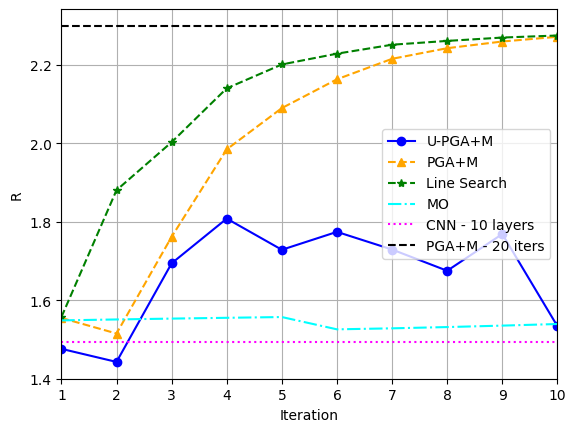

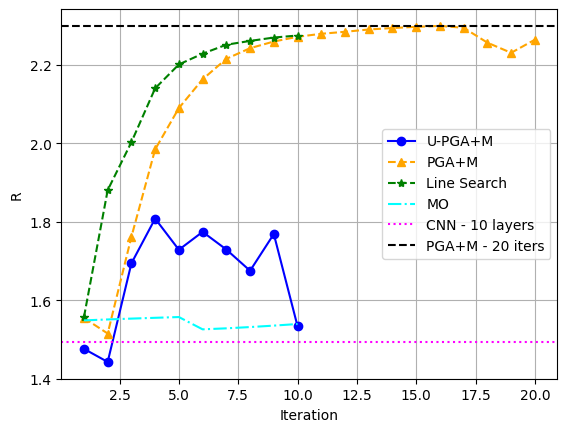

******************* END ******************
******************* START ******************
******************* SNR = 1 ******************
best mu: 1.0, best beta: 0.5, best R: 2.497501
******************* END ******************
******************* START ******************
******************* SNR = 2 ******************
best mu: 4.0, best beta: 0.5, best R: 2.712577
******************* END ******************
******************* START ******************
******************* SNR = 3 ******************
best mu: 1.0, best beta: 0.5, best R: 2.925644
******************* END ******************
******************* START ******************
******************* SNR = 4 ******************
best mu: 1.0, best beta: 0.5, best R: 3.142491
******************* END ******************
******************* START ******************
******************* SNR = 5 ******************
best mu: 4.0, best beta: 0.5, best R: 3.358824
******************* END ******************


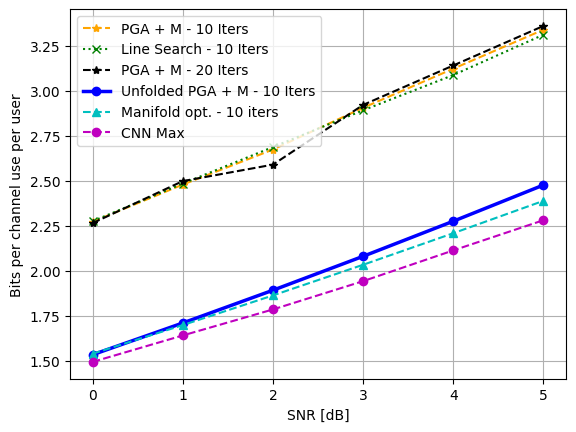

line search max:  [2.2749085426330566, 2.483726978302002, 2.6866462230682373, 2.8905348777770996, 3.08621883392334, 3.3100574016571045]
pga full max:  [2.2641797065734863, 2.4975011348724365, 2.58892822265625, 2.9204578399658203, 3.139371871948242, 3.358823776245117]
pga 10 max:  [2.2715885639190674, 2.478182315826416, 2.67277455329895, 2.904719829559326, 3.121436357498169, 3.3378939628601074]
U-PGA+M:  [1.5339213609695435, 1.7099847793579102, 1.891815185546875, 2.080192804336548, 2.274956226348877, 2.475747585296631]
CNN max:  [1.4939366984006337, 1.6408026107614795, 1.7851813088334723, 1.9422649726467662, 2.11289718688806, 2.280556646498771]
MO:  [1.539414882659912, 1.6982433795928955, 1.862998604774475, 2.0331668853759766, 2.208305835723877, 2.388050079345703]
******************* END ******************


In [ ]:
range_snr = range(0, 6)
pga_m_max, line_search_max, pga_m_10_max, unfolded_max, CNN_max, MO_max = [],[],[],[],[],[]

for SNR in range_snr:
    print("******************* START ******************")
    print("******************* SNR = {} ******************".format(SNR))

    # # Setting parameters
    W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
    epochs, W_is_block_diag, W_is_phase_only, batch_size, \
    pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
    valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
    l1_target, device, sharpness, Q, W_is_finite \
    = set_params(batch_size = 50, train_size = 1, valid_size = 1, pga_iters = 20,
                l1_target = 16/16, gamma = 180, lr_mu_beta=0.001, lambdas_init = 0.0,
                epochs = 5, lr_lambda=0.0001, binary_thresh = -0.2,
                mat_file_path = "/content/H_1100_32_12_5", P=4, L=2, N=3, K=5, B=4,
                Q = 32, W_is_finite = False, sharpness = 80, n_0 = 10**(-0.1*SNR))


    # # Generate the data
    train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

    # # First Benchmark - PGA+M
    c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()
    pga_m_max.append(c_best_Rs[-1].item())
    pga_m_10_max.append(c_best_Rs[J-1].item())

    # # Second Bencmark - Line Search
    ls_best_Rs, ls_best_steps = line_search(ls_iters = J)
    line_search_max.append(ls_best_Rs[-1].item())

    # # Third Benchmark - CNN
    cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
    cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs//5, train_loader, val_loader, cnn= True, plot = False)
    CNN_max.append(abs(cnn_R.cpu().detach().numpy()))

    # # Fourth Benchmark - MO
    MO_best_Rs, MO_best_steps = manifold_optimization(MO_iters = J)
    MO_max.append(MO_best_Rs[-1].item())

    # # Train and plot - Unfolded Algorithm
    u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
    u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
    lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
    unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot = False)
    unfolded_max.append(unfolding_R[-1].item())

    if SNR == 0:
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs)
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs, full=True)
    # plot_norms()
    print("******************* END ******************")



plt.figure()
plt.plot(range_snr, pga_m_10_max, '--*', color="orange", label='PGA + M - {} Iters'.format(J))
plt.plot(range_snr, line_search_max, 'g:x', label='Line Search - {} Iters'.format(J))
plt.plot(range_snr, pga_m_max, '--*', color="black", label='PGA + M - {} Iters'.format(pga_iters))
plt.plot(range_snr, unfolded_max, 'b-o', label='Unfolded PGA + M - {} Iters'.format(J), linewidth=2.5)
plt.plot(range_snr, MO_max, 'c--^', label='Manifold opt. - {} iters'.format(J))
plt.plot(range_snr, CNN_max, 'm--o', label='CNN Max')
plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()
print("line search max: ", line_search_max)
print("pga full max: ", pga_m_max)
print("pga 10 max: ", pga_m_10_max)
print("U-PGA+M: ", unfolded_max)
print("CNN max: ", CNN_max)
print("MO: ", MO_max)
print("******************* END ******************")



###H_1100_32_12_5 - size=250 Finished



******************* START ******************
******************* SNR = 0 ******************
best mu: 0.11, best beta: 0.99, best R: 2.3273
Epoch [50/100], Training: 2.27662, Validation: 2.2243
Epoch [100/100], Training: 2.29153, Validation: 2.19228
Epoch [50/500], Training: 2.21882, Validation: 2.21551
Epoch [100/500], Training: 2.2398, Validation: 2.23774
Epoch [150/500], Training: 2.25758, Validation: 2.25365
Epoch [200/500], Training: 2.2734, Validation: 2.26929
Epoch [250/500], Training: 2.27275, Validation: 2.26941
Epoch [300/500], Training: 2.28086, Validation: 2.27662
Epoch [350/500], Training: 2.28284, Validation: 2.27962
Epoch [400/500], Training: 2.28546, Validation: 2.28269
Epoch [450/500], Training: 2.2806, Validation: 2.27886
Epoch [500/500], Training: 2.28845, Validation: 2.28446


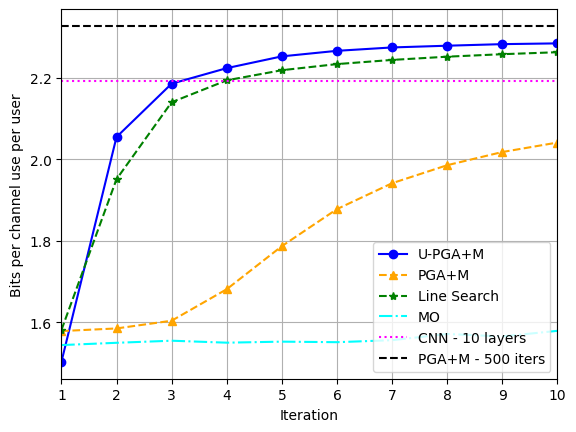

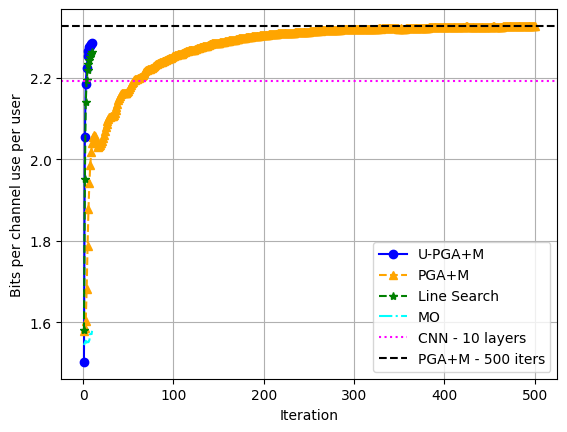

******************* END ******************
******************* START ******************
******************* SNR = 1 ******************
best mu: 0.11, best beta: 0.99, best R: 2.53024
Epoch [50/100], Training: 2.48554, Validation: 2.37344
Epoch [100/100], Training: 2.48859, Validation: 2.43695
Epoch [50/500], Training: 2.43217, Validation: 2.42643
Epoch [100/500], Training: 2.45069, Validation: 2.4473
Epoch [150/500], Training: 2.45027, Validation: 2.44726
Epoch [200/500], Training: 2.45156, Validation: 2.44896
Epoch [250/500], Training: 2.47449, Validation: 2.46078
Epoch [300/500], Training: 2.48585, Validation: 2.48215
Epoch [350/500], Training: 2.48947, Validation: 2.48547
Epoch [400/500], Training: 2.49314, Validation: 2.48804
Epoch [450/500], Training: 2.49372, Validation: 2.48957
Epoch [500/500], Training: 2.4952, Validation: 2.49136
******************* END ******************
******************* START ******************
******************* SNR = 2 ******************
best mu: 0.11,

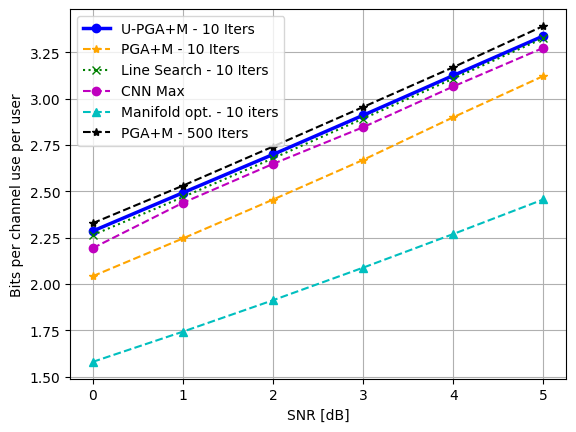

line search max:  [2.2627668380737305, 2.4679605960845947, 2.677037477493286, 2.8913495540618896, 3.1073644161224365, 3.325331449508667]
pga full max:  [2.326948404312134, 2.529454231262207, 2.7407283782958984, 2.9539954662323, 3.1689467430114746, 3.391571044921875]
pga 10 max:  [2.0410315990448, 2.2447562217712402, 2.454540491104126, 2.668773651123047, 2.898956775665283, 3.1216273307800293]
U-PGA+M:  [2.284461259841919, 2.491359233856201, 2.6979174613952637, 2.909515380859375, 3.1241555213928223, 3.3376994132995605]
CNN max:  [2.192281904928231, 2.4369523328279983, 2.6470252522288664, 2.8451707889307714, 3.0649932711245356, 3.2736652494402017]
MO:  [1.5788755416870117, 1.7419023513793945, 1.9115839004516602, 2.0874316692352295, 2.268975257873535, 2.455766201019287]
******************* END ******************


In [ ]:
range_snr = range(0, 6)
pga_m_max, line_search_max, pga_m_10_max, unfolded_max, CNN_max, MO_max = [],[],[],[],[],[]

for SNR in range_snr:
    print("******************* START ******************")
    print("******************* SNR = {} ******************".format(SNR))

    # # Setting parameters
    W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
    epochs, W_is_block_diag, W_is_phase_only, batch_size, \
    pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
    valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
    l1_target, device, sharpness, Q, W_is_finite \
    = set_params(batch_size = 50, train_size = 850, valid_size = 250, pga_iters = 500,
                lr_mu_beta=0.001, epochs = 500, lr_lambda=0.0001, binary_thresh = -0.2,
                mat_file_path = "/content/H_1100_32_12_5", P=4, L=2, N=3, K=5, B=4,
                n_0 = 10**(-0.1*SNR))


    # # Generate the data
    train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

    # # First Benchmark - PGA+M
    c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()
    pga_m_max.append(c_best_Rs[-1].item())
    pga_m_10_max.append(c_best_Rs[J-1].item())

    # # Second Bencmark - Line Search
    ls_best_Rs, ls_best_steps = line_search(ls_iters = J)
    line_search_max.append(ls_best_Rs[-1].item())

    # # Third Benchmark - CNN
    cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
    cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs//5, train_loader, val_loader, cnn= True, plot = False)
    CNN_max.append(abs(cnn_R.cpu().detach().numpy()))

    # # Fourth Benchmark - MO
    MO_best_Rs, MO_best_steps = manifold_optimization(MO_iters = J)
    MO_max.append(MO_best_Rs[-1].item())

    # # Train and plot - Unfolded Algorithm
    u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
    u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
    lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
    unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot = False)
    unfolded_max.append(unfolding_R[-1].item())

    if SNR == 0:
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs)
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs, full=True)
    # plot_norms()
    print("******************* END ******************")



plt.figure()
plt.plot(range_snr, unfolded_max, 'b-o', label='U-PGA+M - {} Iters'.format(J), linewidth=2.5)
plt.plot(range_snr, pga_m_10_max, '--*', color="orange", label='PGA+M - {} Iters'.format(J))
plt.plot(range_snr, line_search_max, 'g:x', label='Line Search - {} Iters'.format(J))
plt.plot(range_snr, CNN_max, 'm--o', label='CNN Max')
plt.plot(range_snr, MO_max, 'c--^', label='Manifold opt. - {} iters'.format(J))
plt.plot(range_snr, pga_m_max, '--*', color="black", label='PGA+M - {} Iters'.format(pga_iters))


plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()
print("line search max: ", line_search_max)
print("pga full max: ", pga_m_max)
print("pga 10 max: ", pga_m_10_max)
print("U-PGA+M: ", unfolded_max)
print("CNN max: ", CNN_max)
print("MO: ", MO_max)
print("******************* END ******************")



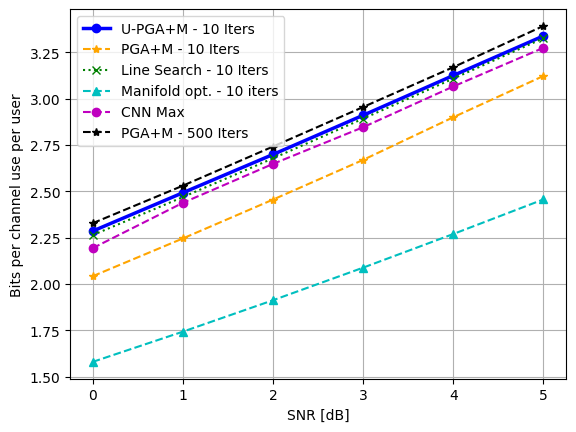

In [ ]:
line_search_max=  [2.2627668380737305, 2.4679605960845947, 2.677037477493286, 2.8913495540618896, 3.1073644161224365, 3.325331449508667]
pga_m_max=  [2.326948404312134, 2.529454231262207, 2.7407283782958984, 2.9539954662323, 3.1689467430114746, 3.391571044921875]
pga_m_10_max=  [2.0410315990448, 2.2447562217712402, 2.454540491104126, 2.668773651123047, 2.898956775665283, 3.1216273307800293]
unfolded_max=  [2.284461259841919, 2.491359233856201, 2.6979174613952637, 2.909515380859375, 3.1241555213928223, 3.3376994132995605]
CNN_max=  [2.192281904928231, 2.4369523328279983, 2.6470252522288664, 2.8451707889307714, 3.0649932711245356, 3.2736652494402017]
MO_max=  [1.5788755416870117, 1.7419023513793945, 1.9115839004516602, 2.0874316692352295, 2.268975257873535, 2.455766201019287]

range_snr = range(0, 6)
J = 10
pga_iters = 500
plt.figure()
plt.plot(range_snr, unfolded_max, 'b-o', label='U-PGA+M - {} Iters'.format(J), linewidth=2.5)
plt.plot(range_snr, pga_m_10_max, '--*', color="orange", label='PGA+M - {} Iters'.format(J))
plt.plot(range_snr, line_search_max, 'g:x', label='Line Search - {} Iters'.format(J))
plt.plot(range_snr, MO_max, 'c--^', label='Manifold opt. - {} iters'.format(J))
plt.plot(range_snr, CNN_max, 'm--o', label='CNN Max')
plt.plot(range_snr, pga_m_max, '--*', color="black", label='PGA+M - {} Iters'.format(pga_iters))


plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()

###H_1250_4_16_6 - size=1 FINISHED






******************* START ******************
******************* SNR = 0 ******************
best mu: 5.0, best beta: 0.5, best R: 2.235715


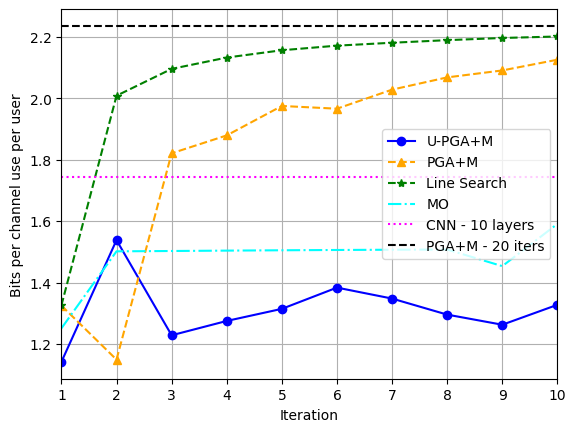

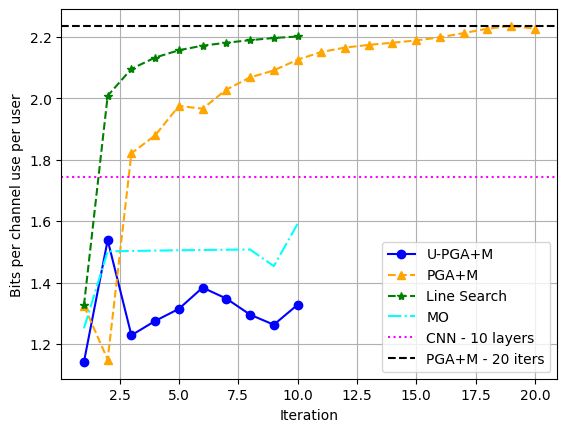

******************* END ******************
******************* START ******************
******************* SNR = 1 ******************
best mu: 2.0, best beta: 0.0, best R: 2.396947
******************* END ******************
******************* START ******************
******************* SNR = 2 ******************
best mu: 2.0, best beta: 0.0, best R: 2.579206
******************* END ******************
******************* START ******************
******************* SNR = 3 ******************
best mu: 4.0, best beta: 0.9, best R: 2.76247
******************* END ******************
******************* START ******************
******************* SNR = 4 ******************
best mu: 3.0, best beta: 0.0, best R: 2.939631
******************* END ******************
******************* START ******************
******************* SNR = 5 ******************
best mu: 4.0, best beta: 0.9, best R: 3.134698
******************* END ******************


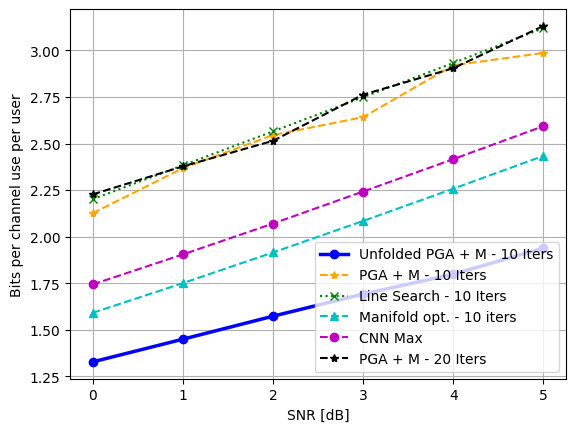

line search max:  [2.2013227939605713, 2.3828299045562744, 2.5652525424957275, 2.7487306594848633, 2.932570695877075, 3.1198537349700928]
pga full max:  [2.2268049716949463, 2.377413034439087, 2.5144591331481934, 2.762470006942749, 2.9046192169189453, 3.1316823959350586]
pga 10 max:  [2.125664472579956, 2.367248773574829, 2.545433759689331, 2.6416311264038086, 2.920233964920044, 2.9864189624786377]
U-PGA+M:  [1.327459454536438, 1.4493299722671509, 1.5729893445968628, 1.691839337348938, 1.7984495162963867, 1.9385981559753418]
CNN max:  [1.7434134247324133, 1.9045009854944317, 2.070303473679715, 2.2424764629204033, 2.4162893972259565, 2.5936098959592835]
MO:  [1.5908869504928589, 1.7503461837768555, 1.9150563478469849, 2.0843374729156494, 2.2575488090515137, 2.4341018199920654]
******************* END ******************


In [ ]:
range_snr = range(0, 6)
pga_m_max, line_search_max, pga_m_10_max, unfolded_max, CNN_max, MO_max = [],[],[],[],[],[]

for SNR in range_snr:
    print("******************* START ******************")
    print("******************* SNR = {} ******************".format(SNR))

    # # Setting parameters
    W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
    epochs, W_is_block_diag, W_is_phase_only, batch_size, \
    pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
    valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
    l1_target, device, sharpness, Q, W_is_finite \
    = set_params(batch_size = 50, train_size = 1, valid_size = 1, pga_iters = 20,
                l1_target = 16/16, gamma = 180, lr_mu_beta=0.001, lambdas_init = 0.0,
                epochs = 5, lr_lambda=0.0001, binary_thresh = -0.2,
                mat_file_path = "/content/H_1250_4_16_6", P=4, L=2, N=4, K=6, B=4,
                Q = 32, W_is_finite = False, sharpness = 80, n_0 = 10**(-0.1*SNR))


    # # Generate the data
    train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

    # # First Benchmark - PGA+M
    c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()
    pga_m_max.append(c_best_Rs[-1].item())
    pga_m_10_max.append(c_best_Rs[J-1].item())

    # # Second Bencmark - Line Search
    ls_best_Rs, ls_best_steps = line_search(ls_iters = J)
    line_search_max.append(ls_best_Rs[-1].item())

    # # Third Benchmark - CNN
    cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
    cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs//5, train_loader, val_loader, cnn= True, plot = False)
    CNN_max.append(abs(cnn_R.cpu().detach().numpy()))

    # # Fourth Benchmark - MO
    MO_best_Rs, MO_best_steps = manifold_optimization(MO_iters = J)
    MO_max.append(MO_best_Rs[-1].item())

    # # Train and plot - Unfolded Algorithm
    u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
    u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
    lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
    unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot = False)
    unfolded_max.append(unfolding_R[-1].item())

    if SNR == 0:
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs)
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs, full=True)
    # plot_norms()
    print("******************* END ******************")



plt.figure()
plt.plot(range_snr, unfolded_max, 'b-o', label='Unfolded PGA + M - {} Iters'.format(J), linewidth=2.5)
plt.plot(range_snr, pga_m_10_max, '--*', color="orange", label='PGA + M - {} Iters'.format(J))
plt.plot(range_snr, line_search_max, 'g:x', label='Line Search - {} Iters'.format(J))
plt.plot(range_snr, MO_max, 'c--^', label ='Manifold opt. - {} iters'.format(J))
plt.plot(range_snr, CNN_max, 'm--o', label='CNN Max')
plt.plot(range_snr, pga_m_max, '--*', color="black", label='PGA + M - {} Iters'.format(pga_iters))

plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()
print("line search max: ", line_search_max)
print("pga full max: ", pga_m_max)
print("pga 10 max: ", pga_m_10_max)
print("U-PGA+M: ", unfolded_max)
print("CNN max: ", CNN_max)
print("MO: ", MO_max)
print("******************* END ******************")



###H_1250_4_16_6 - size=250 Running



******************* START ******************
******************* SNR = 0 ******************
best mu: 0.21, best beta: 0.99, best R: 2.331336
Epoch [50/100], Training: 2.24259, Validation: 2.22211
Epoch [100/100], Training: 2.26775, Validation: 2.21409
Epoch [50/500], Training: 2.10089, Validation: 2.09909
Epoch [100/500], Training: 2.21616, Validation: 2.21129
Epoch [150/500], Training: 2.25364, Validation: 2.24781
Epoch [200/500], Training: 2.26257, Validation: 2.2582
Epoch [250/500], Training: 2.26338, Validation: 2.25875
Epoch [300/500], Training: 2.27226, Validation: 2.26472
Epoch [350/500], Training: 2.27872, Validation: 2.27092
Epoch [400/500], Training: 2.28259, Validation: 2.27726
Epoch [450/500], Training: 2.28231, Validation: 2.27962
Epoch [500/500], Training: 2.28764, Validation: 2.28353


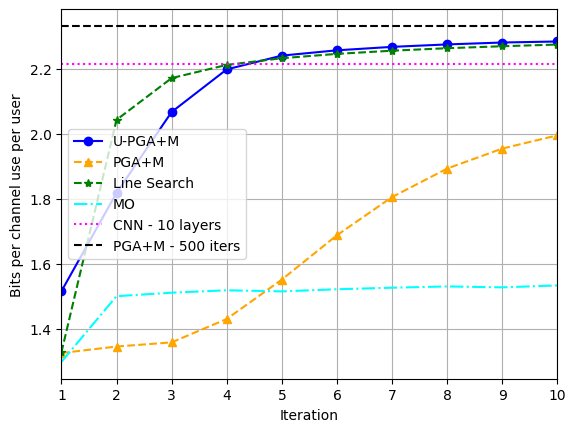

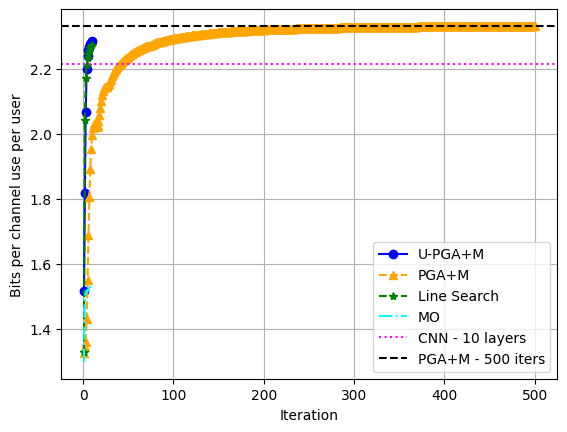

******************* END ******************
******************* START ******************
******************* SNR = 1 ******************
best mu: 0.21, best beta: 0.99, best R: 2.511847
Epoch [50/100], Training: 2.42114, Validation: 2.40076
Epoch [100/100], Training: 2.44643, Validation: 2.39186
Epoch [50/500], Training: 2.29826, Validation: 2.29508
Epoch [100/500], Training: 2.36502, Validation: 2.35729
Epoch [150/500], Training: 2.42585, Validation: 2.4224
Epoch [200/500], Training: 2.43795, Validation: 2.43336
Epoch [250/500], Training: 2.44545, Validation: 2.4413
Epoch [300/500], Training: 2.45181, Validation: 2.4483
Epoch [350/500], Training: 2.44618, Validation: 2.44107
Epoch [400/500], Training: 2.44994, Validation: 2.44303
Epoch [450/500], Training: 2.45269, Validation: 2.44689
Epoch [500/500], Training: 2.45727, Validation: 2.45333
******************* END ******************
******************* START ******************
******************* SNR = 2 ******************
best mu: 0.21,

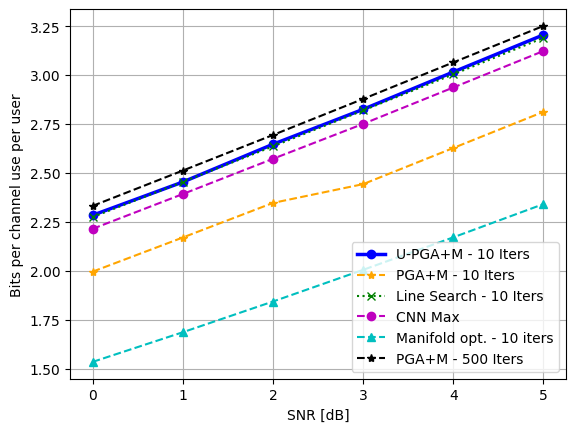

line search max:  [2.2740867137908936, 2.453847885131836, 2.635545253753662, 2.8191463947296143, 3.003610849380493, 3.1902170181274414]
pga full max:  [2.3312864303588867, 2.5118465423583984, 2.693619966506958, 2.8779828548431396, 3.0645947456359863, 3.251105785369873]
pga 10 max:  [1.9951953887939453, 2.16975474357605, 2.3465075492858887, 2.442580461502075, 2.6272547245025635, 2.8120510578155518]
U-PGA+M:  [2.2835326194763184, 2.4533309936523438, 2.6462292671203613, 2.824800968170166, 3.0155961513519287, 3.205535411834717]
CNN max:  [2.214087303904197, 2.3918632677164964, 2.5719476149876415, 2.7504562833516264, 2.9364563120502547, 3.123015403820339]
MO:  [1.5340009927749634, 1.6856533288955688, 1.8426724672317505, 2.0045278072357178, 2.170705795288086, 2.3407163619995117]
******************* END ******************


In [ ]:
range_snr = range(0, 6)
pga_m_max, line_search_max, pga_m_10_max, unfolded_max, CNN_max, MO_max = [],[],[],[],[],[]

for SNR in range_snr:
    print("******************* START ******************")
    print("******************* SNR = {} ******************".format(SNR))

    # # Setting parameters
    W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
    epochs, W_is_block_diag, W_is_phase_only, batch_size, \
    pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
    valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
    l1_target, device, sharpness, Q, W_is_finite \
    = set_params(batch_size = 50, train_size = 1000, valid_size = 250, pga_iters = 500,
                lr_mu_beta=0.001, epochs = 500, lr_lambda=0.0001, binary_thresh = -0.2,
                mat_file_path = "/content/H_1250_4_16_6", P=4, L=2, N=4, K=6, B=4,
                n_0 = 10**(-0.1*SNR))


    # # Generate the data
    train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

    # # First Benchmark - PGA+M
    c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()
    pga_m_max.append(c_best_Rs[-1].item())
    pga_m_10_max.append(c_best_Rs[J-1].item())

    # # Second Bencmark - Line Search
    ls_best_Rs, ls_best_steps = line_search(ls_iters = J)
    line_search_max.append(ls_best_Rs[-1].item())

    # # Third Benchmark - CNN
    cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
    cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs//5, train_loader, val_loader, cnn= True, plot = False)
    CNN_max.append(abs(cnn_R.cpu().detach().numpy()))

    # # Fourth Benchmark - MO
    MO_best_Rs, MO_best_steps = manifold_optimization(MO_iters = J)
    MO_max.append(MO_best_Rs[-1].item())

    # # Train and plot - Unfolded Algorithm
    u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
    u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
    lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
    unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot = False)
    unfolded_max.append(unfolding_R[-1].item())

    if SNR == 0:
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs)
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs, full=True)
    # plot_norms()
    print("******************* END ******************")



plt.figure()
plt.plot(range_snr, unfolded_max, 'b-o', label='U-PGA+M - {} Iters'.format(J), linewidth=2.5)
plt.plot(range_snr, pga_m_10_max, '--*', color="orange", label='PGA+M - {} Iters'.format(J))
plt.plot(range_snr, line_search_max, 'g:x', label='Line Search - {} Iters'.format(J))
plt.plot(range_snr, CNN_max, 'm--o', label='CNN Max')
plt.plot(range_snr, MO_max, 'c--^', label='Manifold opt. - {} iters'.format(J))
plt.plot(range_snr, pga_m_max, '--*', color="black", label='PGA+M - {} Iters'.format(pga_iters))


plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()
print("line search max: ", line_search_max)
print("pga full max: ", pga_m_max)
print("pga 10 max: ", pga_m_10_max)
print("U-PGA+M: ", unfolded_max)
print("CNN max: ", CNN_max)
print("MO: ", MO_max)
print("******************* END ******************")



##Graph 3 - different startings

###H_1100_32_12_5 - size=1 FINISH

best mu: 0.5, best beta: 0.5, best R: 2.310369


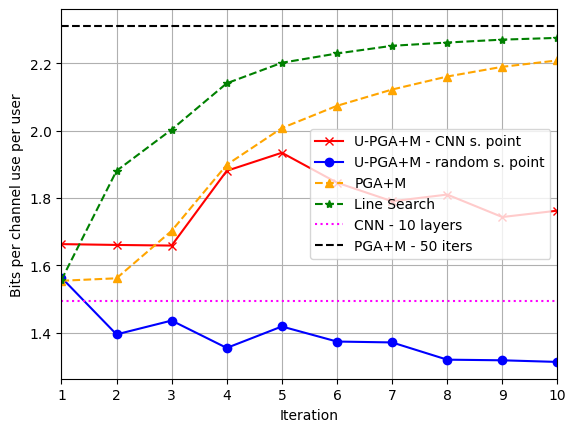

In [ ]:
# # Setting parameters
W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
epochs, W_is_block_diag, W_is_phase_only, batch_size, \
pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
 l1_target, device, sharpness, Q, W_is_finite \
= set_params(batch_size = 50, train_size = 1, valid_size = 1, pga_iters = 50,
             l1_target = 16/16, gamma = 0, lr_mu_beta=0.0007,
             epochs = 5, lr_lambda=0.0003, binary_thresh = -0.2,
             mat_file_path = "/content/H_1100_32_12_5", P=4, L=2, N=3, K=5, B=4)

# # Generate the data
train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

# # # First Benchmark - PGA+M
c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()

# # # Second Bencmark - Line Search
ls_best_Rs, ls_best_steps = line_search(ls_iters = J)

# # # Third Benchmark - CNN
cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs //5, train_loader, val_loader, cnn= True, plot= False)

# # # Train and plot - Unfolded Algorithm
u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot=False)

# # Train Alternatively:
alt_cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(alt_cnn_model.parameters(), lr=0.0001)
alt_u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(alt_u_model.Mu.parameters())+ list(alt_u_model.Beta.parameters()), lr=lr_mu_beta)
lam_optimizer = torch.optim.Adam(alt_u_model.Lambda.parameters(), lr = lr_lambda)
for _ in range(epochs):
    _, alt_cnn_model,_,_ = train_and_plot(alt_cnn_model, 1, train_loader, val_loader, cnn= True, seq_learning = True, pre_model = alt_u_model, plot=False)
    alt_learn_Rs, alt_u_model, _, _ = train_and_plot(alt_u_model, 1, train_loader, val_loader, cnn=False, seq_learning = True, pre_model = alt_cnn_model, plot=False)


indices = np.arange(1,len(c_best_Rs)+1)
u_indices = np.arange(1,len(unfolding_R)+1)
plt.plot(u_indices, alt_learn_Rs.detach().numpy(),"-x", label = "U-PGA+M - CNN s. point", color = "red")
plt.plot(u_indices, unfolding_R,"-o", label='U-PGA+M - random s. point', color = "blue")
plt.plot(indices, c_best_Rs.detach().numpy(),"--^", label = "PGA+M", color = "orange")
plt.plot(u_indices, ls_best_Rs.detach().numpy(),"--*", label = "Line Search", color = "green")
plt.axhline(y=abs(cnn_R.item()), color='magenta', linestyle=':', label="CNN - {} layers".format(cnn_model.cnn_layers))
plt.axhline(y=max(abs(c_best_Rs.detach().numpy())), color='black', linestyle='--', label='PGA+M - {} iters'.format(pga_iters))
plt.xlabel('Iteration')
plt.ylabel("Bits per channel use per user")
plt.legend()
plt.grid()
plt.xlim(1,J)
plt.show()




###H_1100_32_12_5 - size=250 FINISH




<ipython-input-2-b251ad81dd3a>:255: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  Rs[:,iter] = self.calc_R(H, W_2)


best mu: 0.11, best beta: 0.99, best R: 2.3273
Epoch [50/140], Training: 2.27662, Validation: 2.2243
Epoch [100/140], Training: 2.25238, Validation: 2.22011
Epoch [50/700], Training: 2.08979, Validation: 2.09266
Epoch [100/700], Training: 2.20724, Validation: 2.2058
Epoch [150/700], Training: 2.23438, Validation: 2.23293
Epoch [200/700], Training: 2.24666, Validation: 2.24535
Epoch [250/700], Training: 2.25217, Validation: 2.24874
Epoch [300/700], Training: 2.2488, Validation: 2.24762
Epoch [350/700], Training: 2.2607, Validation: 2.25846
Epoch [400/700], Training: 2.26426, Validation: 2.26293
Epoch [450/700], Training: 2.26867, Validation: 2.26638
Epoch [500/700], Training: 2.27529, Validation: 2.27238
Epoch [550/700], Training: 2.28287, Validation: 2.27969
Epoch [600/700], Training: 2.29019, Validation: 2.28698
Epoch [650/700], Training: 2.29398, Validation: 2.29024
Epoch [700/700], Training: 2.29164, Validation: 2.28856


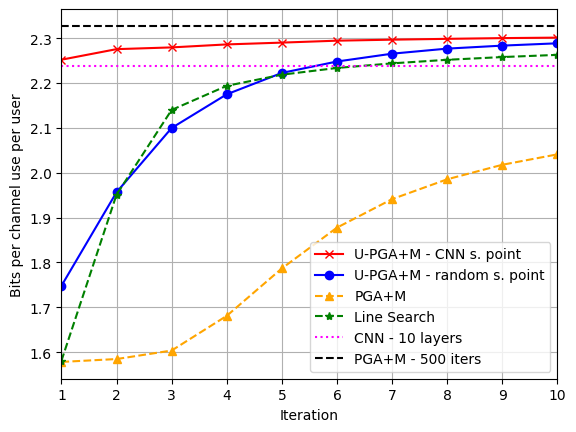

In [ ]:
# # Setting parameters
W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
epochs, W_is_block_diag, W_is_phase_only, batch_size, \
pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
 l1_target, device, sharpness, Q, W_is_finite \
= set_params(batch_size = 50, train_size = 850, valid_size = 250, pga_iters = 500,
             l1_target = 16/16, gamma = 0, lr_mu_beta=0.0007,
             epochs = 700, lr_lambda=0.0003, binary_thresh = -0.2,
             mat_file_path = "/content/H_1100_32_12_5", P=4, L=2, N=3, K=5, B=4)

# # Generate the data
train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

# # # First Benchmark - PGA+M
c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()

# # # Second Bencmark - Line Search
ls_best_Rs, ls_best_steps = line_search(ls_iters = J)

# # # Third Benchmark - CNN
cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs //5, train_loader, val_loader, cnn= True, plot= False)

# # # Train and plot - Unfolded Algorithm
u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot=False)

# # Train Alternatively:
alt_cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(alt_cnn_model.parameters(), lr=0.00005)
alt_u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(alt_u_model.Mu.parameters())+ list(alt_u_model.Beta.parameters()), lr=lr_mu_beta)
lam_optimizer = torch.optim.Adam(alt_u_model.Lambda.parameters(), lr = lr_lambda)
for _ in range(epochs):
    _, alt_cnn_model,_,_ = train_and_plot(alt_cnn_model, 1, train_loader, val_loader, cnn= True, seq_learning = True, pre_model = alt_u_model, plot=False)
    alt_learn_Rs, alt_u_model, _, _ = train_and_plot(alt_u_model, 1, train_loader, val_loader, cnn=False, seq_learning = True, pre_model = alt_cnn_model, plot=False)


indices = np.arange(1,len(c_best_Rs)+1)
u_indices = np.arange(1,len(unfolding_R)+1)
plt.plot(u_indices, alt_learn_Rs.detach().numpy(),"-x", label = "U-PGA+M - CNN s. point", color = "red")
plt.plot(u_indices, unfolding_R,"-o", label='U-PGA+M - random s. point', color = "blue")
plt.plot(indices, c_best_Rs.detach().numpy(),"--^", label = "PGA+M", color = "orange")
plt.plot(u_indices, ls_best_Rs.detach().numpy(),"--*", label = "Line Search", color = "green")
plt.axhline(y=abs(cnn_R.item()), color='magenta', linestyle=':', label="CNN - {} layers".format(cnn_model.cnn_layers))
plt.axhline(y=max(abs(c_best_Rs.detach().numpy())), color='black', linestyle='--', label='PGA+M - {} iters'.format(pga_iters))
plt.xlabel('Iteration')
plt.ylabel("Bits per channel use per user")
plt.legend()
plt.grid()
plt.xlim(1,J)
plt.show()




###H_1250_4_16_6 - size=1 FINISH

best mu: 3.0, best beta: 0.5, best R: 2.243743


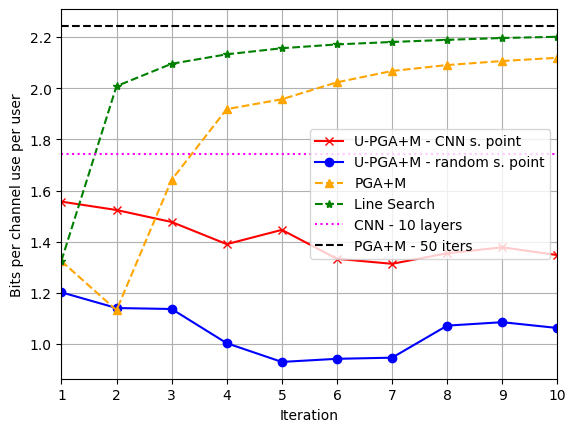

In [ ]:
# # Setting parameters
W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
epochs, W_is_block_diag, W_is_phase_only, batch_size, \
pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
 l1_target, device, sharpness, Q, W_is_finite \
= set_params(batch_size = 50, train_size = 1, valid_size = 1, pga_iters = 50,
             l1_target = 16/16, gamma = 0, lr_mu_beta=0.0007,
             epochs = 5, lr_lambda=0.0003, binary_thresh = -0.2,
             mat_file_path = "/content/H_1250_4_16_6", P=4, L=2, N=4, K=6, B=4)

# # Generate the data
train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

# # # First Benchmark - PGA+M
c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()

# # # Second Bencmark - Line Search
ls_best_Rs, ls_best_steps = line_search(ls_iters = J)

# # # Third Benchmark - CNN
cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs //5, train_loader, val_loader, cnn= True, plot= False)

# # # Train and plot - Unfolded Algorithm
u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot=False)

# # Train Alternatively:
alt_cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(alt_cnn_model.parameters(), lr=0.0001)
alt_u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(alt_u_model.Mu.parameters())+ list(alt_u_model.Beta.parameters()), lr=lr_mu_beta)
lam_optimizer = torch.optim.Adam(alt_u_model.Lambda.parameters(), lr = lr_lambda)
for _ in range(epochs):
    _, alt_cnn_model,_,_ = train_and_plot(alt_cnn_model, 1, train_loader, val_loader, cnn= True, seq_learning = True, pre_model = alt_u_model, plot=False)
    alt_learn_Rs, alt_u_model, _, _ = train_and_plot(alt_u_model, 1, train_loader, val_loader, cnn=False, seq_learning = True, pre_model = alt_cnn_model, plot=False)


indices = np.arange(1,len(c_best_Rs)+1)
u_indices = np.arange(1,len(unfolding_R)+1)
plt.plot(u_indices, alt_learn_Rs.detach().numpy(),"-x", label = "U-PGA+M - CNN s. point", color = "red")
plt.plot(u_indices, unfolding_R,"-o", label='U-PGA+M - random s. point', color = "blue")
plt.plot(indices, c_best_Rs.detach().numpy(),"--^", label = "PGA+M", color = "orange")
plt.plot(u_indices, ls_best_Rs.detach().numpy(),"--*", label = "Line Search", color = "green")
plt.axhline(y=abs(cnn_R.item()), color='magenta', linestyle=':', label="CNN - {} layers".format(cnn_model.cnn_layers))
plt.axhline(y=max(abs(c_best_Rs.detach().numpy())), color='black', linestyle='--', label='PGA+M - {} iters'.format(pga_iters))
plt.xlabel('Iteration')
plt.ylabel("Bits per channel use per user")
plt.legend()
plt.grid()
plt.xlim(1,J)
plt.show()




###H_1250_4_16_6 - size=250 - Running




<ipython-input-2-b251ad81dd3a>:255: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  Rs[:,iter] = self.calc_R(H, W_2)


best mu: 0.21, best beta: 0.99, best R: 2.331336
Epoch [50/200], Training: 2.24259, Validation: 2.22211
Epoch [100/200], Training: 2.26775, Validation: 2.21409
Epoch [150/200], Training: 2.28856, Validation: 2.20495
Epoch [200/200], Training: 2.30185, Validation: 2.19998
Epoch [50/1000], Training: 2.02285, Validation: 2.03129
Epoch [100/1000], Training: 2.16837, Validation: 2.15846
Epoch [150/1000], Training: 2.25024, Validation: 2.23946
Epoch [200/1000], Training: 2.26434, Validation: 2.26026
Epoch [250/1000], Training: 2.26306, Validation: 2.25652
Epoch [300/1000], Training: 2.27221, Validation: 2.26529
Epoch [350/1000], Training: 2.28223, Validation: 2.27702
Epoch [400/1000], Training: 2.2849, Validation: 2.28019
Epoch [450/1000], Training: 2.28498, Validation: 2.27998
Epoch [500/1000], Training: 2.28871, Validation: 2.28414
Epoch [550/1000], Training: 2.29241, Validation: 2.28685
Epoch [600/1000], Training: 2.29441, Validation: 2.28997
Epoch [650/1000], Training: 2.29703, Validatio

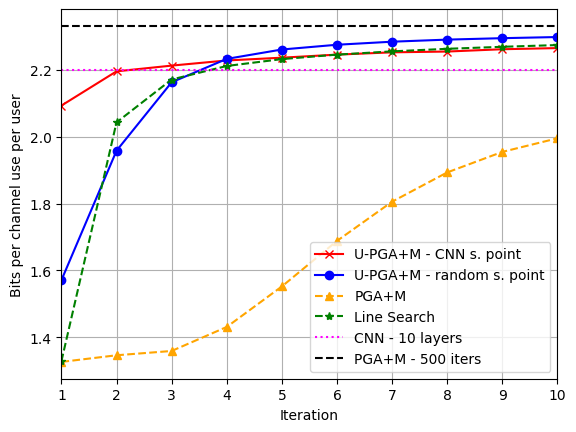

In [ ]:
# # Setting parameters
W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
epochs, W_is_block_diag, W_is_phase_only, batch_size, \
pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
 l1_target, device, sharpness, Q, W_is_finite \
= set_params(batch_size = 50, train_size = 1000, valid_size = 250, pga_iters = 500,
             l1_target = 16/16, gamma = 0, lr_mu_beta=0.0007,
             epochs = 1000, lr_lambda=0.0003, binary_thresh = -0.2,
             mat_file_path = "/content/H_1250_4_16_6", P=4, L=2, N=4, K=6, B=4)

# # Generate the data
train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "QuaDRiGA")

# # # First Benchmark - PGA+M
c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()

# # # Second Bencmark - Line Search
ls_best_Rs, ls_best_steps = line_search(ls_iters = J)

# # # Third Benchmark - CNN
cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs //5, train_loader, val_loader, cnn= True, plot= False)

# # # Train and plot - Unfolded Algorithm
u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot=False)

# # Train Alternatively:
alt_cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
cnn_optimizer = torch.optim.Adam(alt_cnn_model.parameters(), lr=0.0001)
alt_u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
u_optimizer = torch.optim.Adam(list(alt_u_model.Mu.parameters())+ list(alt_u_model.Beta.parameters()), lr=lr_mu_beta/2)
lam_optimizer = torch.optim.Adam(alt_u_model.Lambda.parameters(), lr = lr_lambda/2)
for _ in range(epochs):
    _, alt_cnn_model,_,_ = train_and_plot(alt_cnn_model, 1, train_loader, val_loader, cnn= True, seq_learning = True, pre_model = alt_u_model, plot=False)
    alt_learn_Rs, alt_u_model, _, _ = train_and_plot(alt_u_model, 1, train_loader, val_loader, cnn=False, seq_learning = True, pre_model = alt_cnn_model, plot=False)


indices = np.arange(1,len(c_best_Rs)+1)
u_indices = np.arange(1,len(unfolding_R)+1)
plt.plot(u_indices, alt_learn_Rs.detach().numpy(),"-x", label = "U-PGA+M - CNN s. point", color = "red")
plt.plot(u_indices, unfolding_R,"-o", label='U-PGA+M - random s. point', color = "blue")
plt.plot(indices, c_best_Rs.detach().numpy(),"--^", label = "PGA+M", color = "orange")
plt.plot(u_indices, ls_best_Rs.detach().numpy(),"--*", label = "Line Search", color = "green")
plt.axhline(y=abs(cnn_R.item()), color='magenta', linestyle=':', label="CNN - {} layers".format(cnn_model.cnn_layers))
plt.axhline(y=max(abs(c_best_Rs.detach().numpy())), color='black', linestyle='--', label='PGA+M - {} iters'.format(pga_iters))
plt.xlabel('Iteration')
plt.ylabel("Bits per channel use per user")
plt.legend()
plt.grid()
plt.xlim(1,J)
plt.show()




##Graphs 4+5 - R vs. SNR, R vs. Iteration


###IID- size=1 Finished






******************* START ******************
******************* SNR = 0 ******************


<ipython-input-4-b251ad81dd3a>:320: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample)


best mu: 5.0, best beta: 0.9, best R: 0.979997


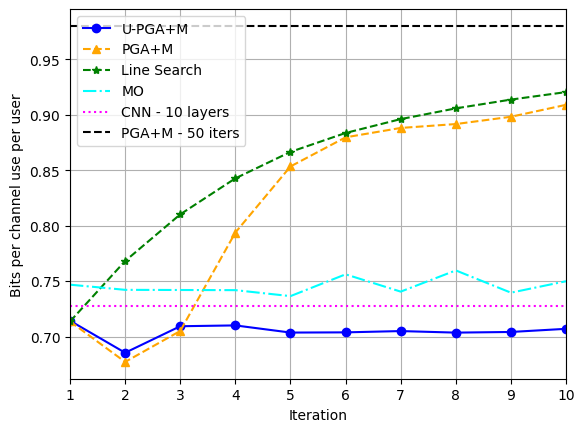

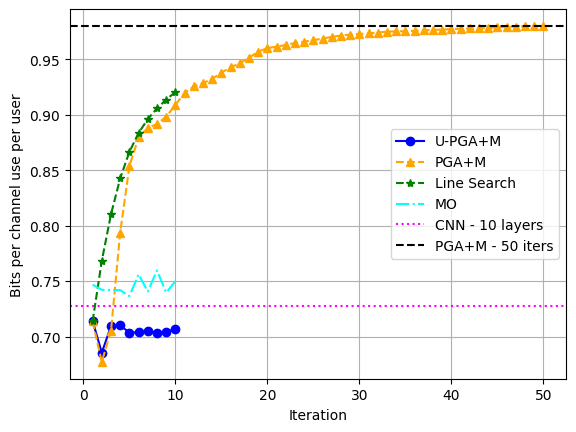

******************* END ******************
******************* START ******************
******************* SNR = 1 ******************
best mu: 5.0, best beta: 0.9, best R: 1.036677
******************* END ******************
******************* START ******************
******************* SNR = 2 ******************
best mu: 5.0, best beta: 0.9, best R: 1.093523
******************* END ******************
******************* START ******************
******************* SNR = 3 ******************
best mu: 5.0, best beta: 0.9, best R: 1.150127
******************* END ******************
******************* START ******************
******************* SNR = 4 ******************
best mu: 5.0, best beta: 0.9, best R: 1.20772
******************* END ******************
******************* START ******************
******************* SNR = 5 ******************
best mu: 5.0, best beta: 0.9, best R: 1.26509
******************* END ******************


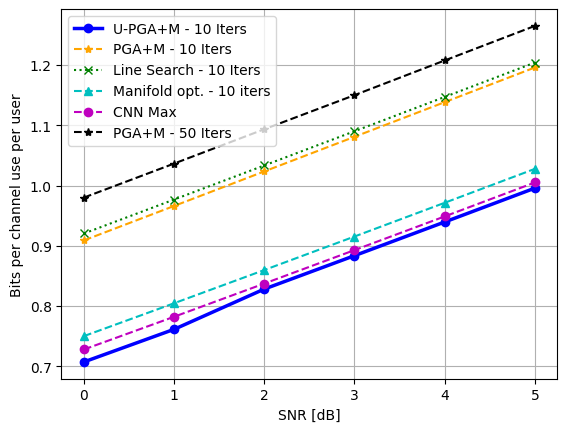

line search max:  [0.920364499092102, 0.9767590761184692, 1.0333726406097412, 1.0901679992675781, 1.1471128463745117, 1.2041796445846558]
pga full max:  [0.9799970388412476, 1.0364868640899658, 1.093522548675537, 1.1501269340515137, 1.207720398902893, 1.265089750289917]
pga 10 max:  [0.9088872075080872, 0.9660669565200806, 1.0234333276748657, 1.0809166431427002, 1.138465166091919, 1.1960456371307373]
U-PGA+M:  [0.7070070505142212, 0.7611808180809021, 0.8280432820320129, 0.8835158348083496, 0.9394353628158569, 0.9956640005111694]
CNN max:  [0.7277006096113839, 0.7820489819826777, 0.8371773847481846, 0.8927542831227182, 0.9486819390482236, 1.0050235132226948]
MO:  [0.74989253282547, 0.8044870495796204, 0.8596600294113159, 0.9153038859367371, 0.9713292121887207, 1.0276622772216797]
******************* END ******************


In [ ]:
range_snr = range(0, 6)
pga_m_max, line_search_max, pga_m_10_max, unfolded_max, CNN_max, MO_max = [],[],[],[],[],[]

for SNR in range_snr:
    print("******************* START ******************")
    print("******************* SNR = {} ******************".format(SNR))

    # # Setting parameters
    W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
    epochs, W_is_block_diag, W_is_phase_only, batch_size, \
    pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
    valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
    l1_target, device, sharpness, Q, W_is_finite \
    = set_params(epochs = 5, B=2, K=20, P=2, N=20, L=4, pga_iters = 50,
             batch_size = 75, train_size = 1, valid_size = 1,
             lr_mu_beta = 0.007, lr_lambda=0.001, n_0 = 10**(-0.1*SNR))


    # # Generate the data
    train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "I.I.D.")

    # # First Benchmark - PGA+M
    c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()
    pga_m_max.append(c_best_Rs[-1].item())
    pga_m_10_max.append(c_best_Rs[J-1].item())

    # # Second Bencmark - Line Search
    ls_best_Rs, ls_best_steps = line_search(ls_iters = J)
    line_search_max.append(ls_best_Rs[-1].item())

    # # Third Benchmark - CNN
    cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
    cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs//5, train_loader, val_loader, cnn= True, plot = False)
    CNN_max.append(abs(cnn_R.cpu().detach().numpy()))

    # # Fourth Benchmark - MO
    MO_best_Rs, MO_best_steps = manifold_optimization(MO_iters = J)
    MO_max.append(MO_best_Rs[-1].item())

    # # Train and plot - Unfolded Algorithm
    u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
    u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
    lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
    unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot = False)
    unfolded_max.append(unfolding_R[-1].item())

    if SNR == 0:
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs)
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs, full=True)
    # plot_norms()
    print("******************* END ******************")



plt.figure()
plt.plot(range_snr, unfolded_max, 'b-o', label='U-PGA+M - {} Iters'.format(J), linewidth=2.5)
plt.plot(range_snr, pga_m_10_max, '--*', color="orange", label='PGA+M - {} Iters'.format(J))
plt.plot(range_snr, line_search_max, 'g:x', label='Line Search - {} Iters'.format(J))
plt.plot(range_snr, MO_max, 'c--^', label='Manifold opt. - {} iters'.format(J))
plt.plot(range_snr, CNN_max, 'm--o', label='CNN Max')
plt.plot(range_snr, pga_m_max, '--*', color="black", label='PGA+M - {} Iters'.format(pga_iters))
plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()
print("line search max: ", line_search_max)
print("pga full max: ", pga_m_max)
print("pga 10 max: ", pga_m_10_max)
print("U-PGA+M: ", unfolded_max)
print("CNN max: ", CNN_max)
print("MO: ", MO_max)
print("******************* END ******************")



###IID - size=250 Finished

******************* START ******************
******************* SNR = 0 ******************


<ipython-input-4-b251ad81dd3a>:320: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample)


best mu: 1.0, best beta: 0.99, best R: 0.984651
Epoch [50/100], Training: 0.73179, Validation: 0.73228
Epoch [100/100], Training: 0.73021, Validation: 0.73185
Epoch [50/500], Training: 0.90372, Validation: 0.90396
Epoch [100/500], Training: 0.92232, Validation: 0.92027
Epoch [150/500], Training: 0.93306, Validation: 0.93039
Epoch [200/500], Training: 0.93872, Validation: 0.93605
Epoch [250/500], Training: 0.94327, Validation: 0.94037
Epoch [300/500], Training: 0.94508, Validation: 0.94246
Epoch [350/500], Training: 0.94781, Validation: 0.94533
Epoch [400/500], Training: 0.94887, Validation: 0.94612
Epoch [450/500], Training: 0.95112, Validation: 0.94821
Epoch [500/500], Training: 0.95194, Validation: 0.94926


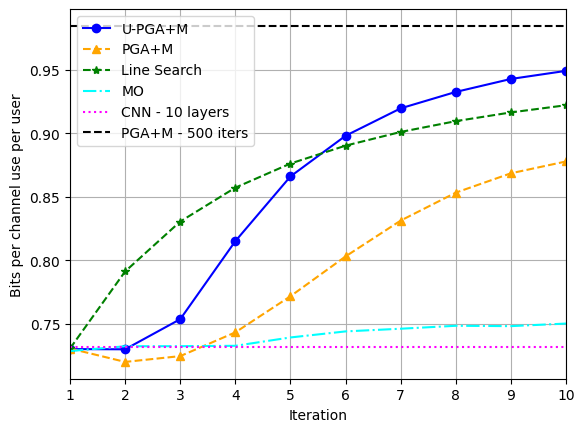

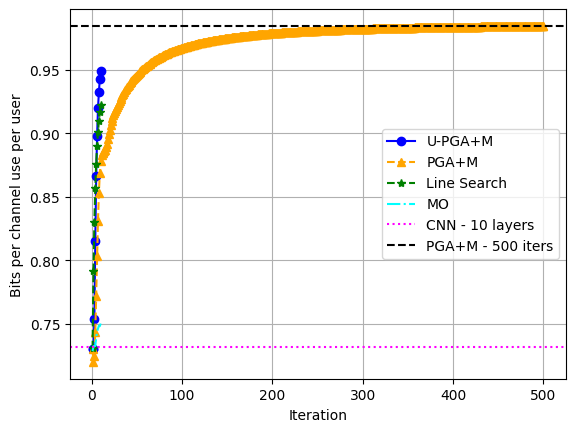

******************* END ******************
******************* START ******************
******************* SNR = 1 ******************
best mu: 1.0, best beta: 0.99, best R: 1.041184
Epoch [50/100], Training: 0.78822, Validation: 0.78705
Epoch [100/100], Training: 0.78566, Validation: 0.78564
Epoch [50/500], Training: 0.95977, Validation: 0.96035
Epoch [100/500], Training: 0.98054, Validation: 0.97851
Epoch [150/500], Training: 0.98953, Validation: 0.98722
Epoch [200/500], Training: 0.99431, Validation: 0.99163
Epoch [250/500], Training: 0.99885, Validation: 0.99671
Epoch [300/500], Training: 1.00115, Validation: 0.99858
Epoch [350/500], Training: 1.00362, Validation: 1.00119
Epoch [400/500], Training: 1.00567, Validation: 1.00279
Epoch [450/500], Training: 1.00793, Validation: 1.00476
Epoch [500/500], Training: 1.00921, Validation: 1.00658
******************* END ******************
******************* START ******************
******************* SNR = 2 ******************
best mu: 1.0

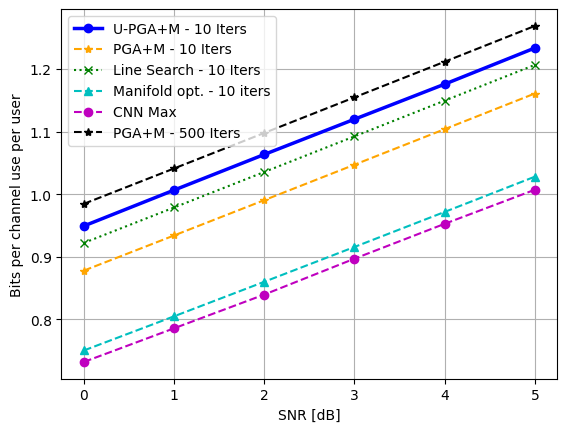

line search max:  [0.9221790432929993, 0.9787777066230774, 1.0355687141418457, 1.0925028324127197, 1.1495834589004517, 1.2067601680755615]
pga full max:  [0.9846510887145996, 1.0411839485168457, 1.0979502201080322, 1.1548422574996948, 1.2118217945098877, 1.2690316438674927]
pga 10 max:  [0.8778911828994751, 0.9340635538101196, 0.9905028939247131, 1.0471625328063965, 1.1040012836456299, 1.1609854698181152]
U-PGA+M:  [0.9492589831352234, 1.006583333015442, 1.0635356903076172, 1.1198629140853882, 1.1759498119354248, 1.2337405681610107]
CNN max:  [0.7318451896909229, 0.7856368850063091, 0.8395433855113044, 0.896903366173744, 0.9526586006618301, 1.0071195878930106]
MO:  [0.7502166032791138, 0.8048181533813477, 0.8599960207939148, 0.9156430959701538, 0.9716706275939941, 1.0280053615570068]
******************* END ******************


In [ ]:
range_snr = range(0, 6)
pga_m_max, line_search_max, pga_m_10_max, unfolded_max, CNN_max, MO_max = [],[],[],[],[],[]

for SNR in range_snr:
    print("******************* START ******************")
    print("******************* SNR = {} ******************".format(SNR))

    # # Setting parameters
    W, B, K, P, N, M, L, T, snr, A, Ik, Im, D, J,\
    epochs, W_is_block_diag, W_is_phase_only, batch_size, \
    pga_iters, lr_mu_beta, lr_lambda, binary_thresh, train_size,\
    valid_size, lambdas_init, gamma ,mat_file_path, project_every,\
    l1_target, device, sharpness, Q, W_is_finite \
    = set_params(epochs = 500, B=2, K=20, P=2, N=20, L=4, pga_iters = 500,
             batch_size = 75, train_size = 1200, valid_size = 300,
             lr_mu_beta = 0.007, lr_lambda=0.001, n_0 = 10**(-0.1*SNR))


    # # Generate the data
    train_loader, val_loader, val_loader_sin = gen_data(train_size, valid_size, "I.I.D.")

# # First Benchmark - PGA+M
    c_best_Rs, best_mu, best_beta = constant_mu_and_beta_search()
    pga_m_max.append(c_best_Rs[-1].item())
    pga_m_10_max.append(c_best_Rs[J-1].item())

    # # Second Bencmark - Line Search
    ls_best_Rs, ls_best_steps = line_search(ls_iters = J)
    line_search_max.append(ls_best_Rs[-1].item())

    # # Third Benchmark - CNN
    cnn_model = FastTrainUnfolding(W,J,"CNN").to(device)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
    cnn_R,cnn_model,_,_ = train_and_plot(cnn_model, epochs//5, train_loader, val_loader, cnn= True, plot = False)
    CNN_max.append(abs(cnn_R.cpu().detach().numpy()))

    # # Fourth Benchmark - MO
    MO_best_Rs, MO_best_steps = manifold_optimization(MO_iters = J)
    MO_max.append(MO_best_Rs[-1].item())

    # # Train and plot - Unfolded Algorithm
    u_model = FastTrainUnfolding(W,J,"Unfolding").to(device)
    u_optimizer = torch.optim.Adam(list(u_model.Mu.parameters())+ list(u_model.Beta.parameters()), lr=lr_mu_beta)
    lam_optimizer = torch.optim.Adam(u_model.Lambda.parameters(), lr = lr_lambda)
    unfolding_R, u_model, u_l1_norms_v, u_l1_norms_t = train_and_plot(u_model, epochs, train_loader, val_loader, plot = False)
    unfolded_max.append(unfolding_R[-1].item())

    if SNR == 0:
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs)
        plot_R(unfolding_R, c_best_Rs, ls_best_Rs, cnn_R, MO_best_Rs, full=True)
    # plot_norms()
    print("******************* END ******************")



plt.figure()
plt.plot(range_snr, unfolded_max, 'b-o', label='U-PGA+M - {} Iters'.format(J), linewidth=2.5)
plt.plot(range_snr, pga_m_10_max, '--*', color="orange", label='PGA+M - {} Iters'.format(J))
plt.plot(range_snr, line_search_max, 'g:x', label='Line Search - {} Iters'.format(J))
plt.plot(range_snr, MO_max, 'c--^', label='Manifold opt. - {} iters'.format(J))
plt.plot(range_snr, CNN_max, 'm--o', label='CNN Max')
plt.plot(range_snr, pga_m_max, '--*', color="black", label='PGA+M - {} Iters'.format(pga_iters))
plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()
print("line search max: ", line_search_max)
print("pga full max: ", pga_m_max)
print("pga 10 max: ", pga_m_10_max)
print("U-PGA+M: ", unfolded_max)
print("CNN max: ", CNN_max)
print("MO: ", MO_max)
print("******************* END ******************")

